### Imports

In [82]:
import os
import math

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(style="whitegrid")

In [3]:
import mixtureofconcave as subm
import determinantal as logsubm
import plottingtools

---

### A log-submodular function : DPP

In [4]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))

K = X @ X.transpose()
ground = np.linalg.det(K)

In [5]:
S, objectives = logsubm.greedygains_logsubmod(None, X, k)

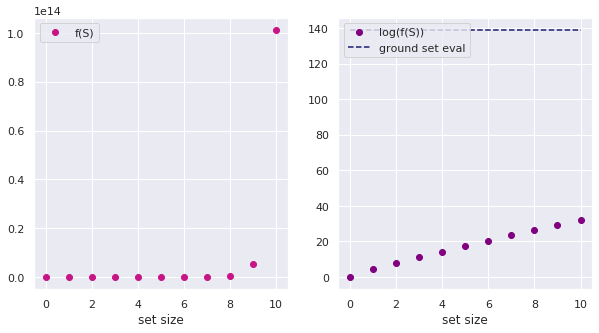

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plottingtools.objplot(objectives, ground, "mediumvioletred")
plt.subplot(1,2,2)
plottingtools.logobjplot(objectives, ground, "purple", "midnightblue")

In [7]:
for oo in objectives: print("{:.3f}".format(oo))

1.000
74.940
2486.709
63555.810
1487750.070
31893574.032
677766067.108
14108951137.618
276220495859.501
5396136349373.081
101255403669399.172


---

### A submodular function : a weighted mixture of m(A)^{0.2}

In [8]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

ground = np.dot(mixw, np.sum(X, axis=0)**0.2)

In [9]:
S, objectives = subm.greedygains_submod(None, X, mixw, k)

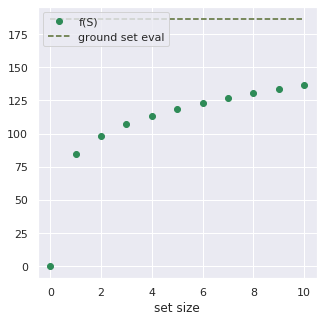

In [10]:
plt.figure(figsize=(5,5))
plottingtools.objplot(objectives, ground, "seagreen", "darkolivegreen")

In [11]:
for oo in objectives: print("{:.3f}".format(oo))

0.000
84.346
98.494
107.093
113.569
118.826
123.244
127.106
130.542
133.648
136.481


---

### DPP v/s Submodular

In [12]:
n = 500
m = 72
k = 25

np.random.seed(0)
X = np.random.random((n, m))

np.random.seed(1)
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

In [13]:
S_d, objectives_d = logsubm.greedygains_logsubmod(None, X, k)

In [14]:
S_s, objectives_s = subm.greedygains_submod(None, X, mixw, k)

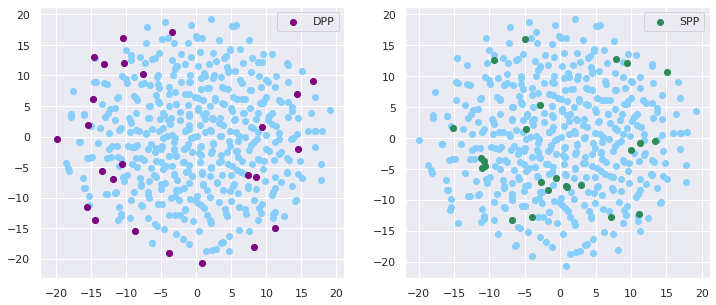

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plottingtools.viztsne(X, S_d, "purple", "DPP", 30)
plt.subplot(1,2,2)
plottingtools.viztsne(X, S_s, "seagreen", "SPP", 30)

---

### Greedy v/s WeightedGreedy

Compare:<br>
Feasibility, output quality, computational complexity.

---

<p style="background-color:#ff9933">
Constrained Submodular Max with Discrete Membership Quota
</p>

#ccff66 #ff99cc #ff9933

..

In [71]:
def greedyquota_submod(V, X, mixw, Memvec, quo, k):
    """ For the disjoint membership quota.
        Memvec is an n x p one-hot matrix (exactly one 1 per row).
        quo is a p x 1 vector.
        Output a subset that satisfies the quotas.
    """
    
    [n,m] = X.shape
    
    if V == None:
        V = np.arange(n)
    
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    modA = np.sum(X[A,:], axis=0)
    ff = 0 # assume normalized for now
    objs[0] = ff
    
    """ Quota-filling stage """
    
    ii = 0
    Vsat = np.copy(V) # only for use in the quota-filling stage
    while ii < np.sum(quo):
        
        maxgain = -100
        greedyv = np.random.choice(Vsat)
        
        for vidx in range(len(Vsat)):
            gain = subm.submodgains(X, modA, ff, Vsat[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = Vsat[vidx]
        
        # add element to A, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        ff += maxgain
        objs[ii+1] = ff
        
        # remove from V, remove all from Vsat if quota filled
        V = V[V!=greedyv]
        grp = np.argwhere(Memvec[greedyv])
        if np.sum(Memvec[A,grp]) >= quo[grp]:
            Vsat = np.delete(V, np.argwhere(Memvec[:,grp]))
        
        ii += 1
    
    
    """ Regular greedy stage """
    
    while ii < k:
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = subm.submodgains(X, modA, ff, V[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
        
        ii += 1
    
    return A, objs

In [90]:
def viztsne_DMQ(X, Memvec, memcolors, S, setcolor, setlabel, perp):
    """ Given an nxm feature matrix X
        A selection of indices S of size k < n
        An n x p Membership matrix for p groups
        Plot the selection's 2d TSNE
    """
    
    [n,m] = X.shape
    p = Memvec.shape[1]
    
    Xemb = TSNE(n_components=2, random_state=256).fit_transform(X)
    
    for jj in range(p):
        memgrp = np.argwhere(Memvec[:,jj])
        plt.scatter(Xemb[memgrp,0], Xemb[memgrp,1], c=memcolors[jj])
    plt.scatter(Xemb[S,0], Xemb[S,1], facecolors="none", edgecolors=setcolor, linewidth=3, label=setlabel)
    plt.legend()

In [64]:
n_samples = 200
m_features = 72
k_budget = 30

np.random.seed(0)
X = np.random.random((n_samples, m_features))

np.random.seed(1)
mixw = np.random.random(m_features); mixw = mixw/np.max(mixw)

In [77]:
p_groups = 10
memcolors = ["steelblue", "lightsteelblue", "lightskyblue", "lightslategrey", "dodgerblue", "deepskyblue", "turquoise", "aquamarine", "lightseagreen", "mediumaquamarine"]

Memvec = np.eye(p_groups)[np.random.choice(p_groups, n_samples)]
quo = np.ones(p_groups)*2

In [66]:
for jj in range(p):
    print(len(np.argwhere(Memvec[:,jj])))

26
17
21
18
22
18
21
23
17
17


In [67]:
S_s, objectives_s = subm.greedygains_submod(None, X, mixw, k)

In [72]:
S_sq, objectives_sq = greedyquota_submod(None, X, mixw, Memvec, quo, k)

/home/neeraja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


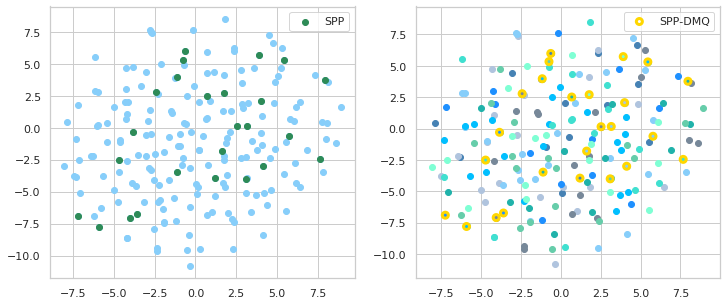

In [91]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plottingtools.viztsne(X, S_s, "seagreen", "SPP", 30)
plt.subplot(1,2,2)
#plottingtools.
viztsne_DMQ(X, Memvec, memcolors, S_sq, "gold", "SPP-DMQ", 30)

---

In [84]:
print(objectives_s)
print(objectives_sq)

[ 0.         29.48785677 34.36354247 37.26450742 39.49875738 41.3006504
 42.82786665 44.1680903  45.36145216 46.43505087 47.40667547 48.30793102
 49.14324824 49.92360115 50.65926751 51.35088186 52.00244242 52.62236054
 53.21317501 53.77745441 54.31751513 54.83457039 55.32993025 55.8068317
 56.26737637 56.71238021]
[ 0.         29.48785677 34.36354247 37.26450742 39.49875738 41.3006504
 42.82786665 44.1680903  45.36145216 46.43505087 47.40667547 48.30793102
 49.14324824 49.92360115 50.65926751 51.35088186 52.00244242 52.62236054
 53.21317501 53.77745441 54.31751513 54.83457039 55.32993025 55.8068317
 56.26737637 56.71238021]
